In [19]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

In [20]:
# Set paths
input_file_path = 'dataset/Reviews.csv'  # Path to your dataset
output_dir = 'output2'  # Directory to save outputs
os.makedirs(output_dir, exist_ok=True)

# Load dataset
data = pd.read_csv(input_file_path)
data.to_csv(os.path.join(output_dir, 'step1_loaded_data.csv'), index=False)

In [22]:
# Text Preprocessing
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    text = text.lower()  # Convert to lowercase
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return ' '.join(tokens)

In [23]:
data['ProcessedText'] = data['Text'].apply(preprocess_text)
data.to_csv(os.path.join(output_dir, 'step2_preprocessed_text.csv'), index=False)

In [24]:
# Sentiment and Feature Extraction
data['SentimentScore'] = data['ProcessedText'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Extract Key Phrases (TF-IDF)
vectorizer = TfidfVectorizer(max_features=10)
tfidf_matrix = vectorizer.fit_transform(data['ProcessedText'])
key_phrases = vectorizer.get_feature_names_out()
data['KeyPhrases'] = tfidf_matrix.toarray().tolist()

In [5]:
# Topic Modeling using LDA
count_vectorizer = CountVectorizer(max_features=10)
count_matrix = count_vectorizer.fit_transform(data['ProcessedText'])
lda = LatentDirichletAllocation(n_components=3, random_state=42)  # Extract 3 topics
data['Topics'] = lda.fit_transform(count_matrix).tolist()

In [6]:
data.to_csv(os.path.join(output_dir, 'step3_sentiment_features.csv'), index=False)

In [7]:
# Feature Engineering
features = pd.DataFrame(tfidf_matrix.toarray(), columns=[f'TF-IDF_{k}' for k in key_phrases])
features['SentimentScore'] = data['SentimentScore']
features['HelpfulnessNumerator'] = data['HelpfulnessNumerator']
features['HelpfulnessDenominator'] = data['HelpfulnessDenominator']
features['Score'] = data['Score']
features['Topic_0'] = [topic[0] for topic in data['Topics']]
features['Topic_1'] = [topic[1] for topic in data['Topics']]
features['Topic_2'] = [topic[2] for topic in data['Topics']]

# Save engineered features
features.to_csv(os.path.join(output_dir, 'step4_feature_engineering.csv'), index=False)

In [8]:
# Predictive Modeling
X = features.drop('Score', axis=1)
y = features['Score']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Train Gradient Boosting Regressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor()

In [10]:
# Predictions
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [11]:
# Save model predictions
test_results = X_test.copy()
test_results['Actual'] = y_test
test_results['Predicted'] = y_pred
test_results.to_csv(os.path.join(output_dir, 'step5_predictions.csv'), index=False)

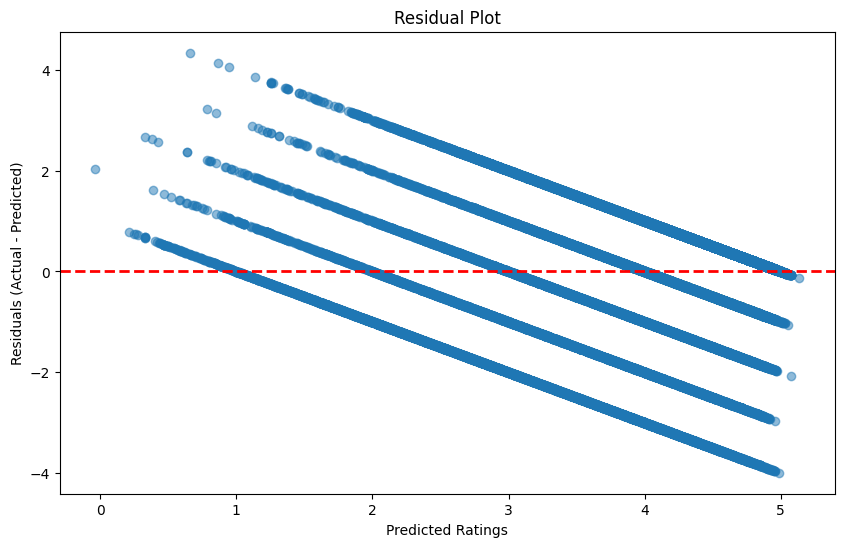

In [12]:
# Residual Plot
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.savefig(os.path.join(output_dir, 'residual_plot.png'))
plt.show()

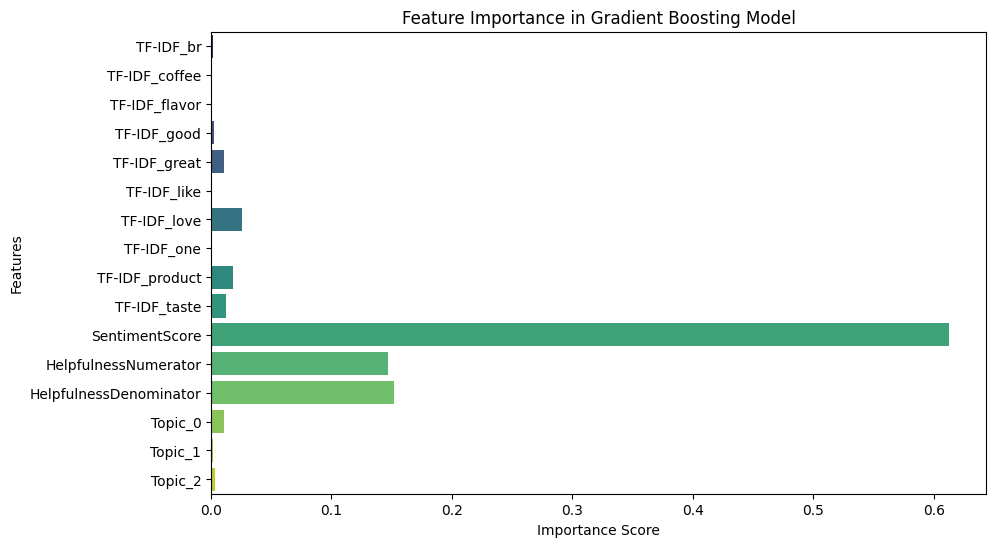

In [16]:
# Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = model.feature_importances_
feature_names = X.columns
sns.barplot(x=feature_importances, y=feature_names, hue=feature_names, dodge=False, palette='viridis')
plt.title('Feature Importance in Gradient Boosting Model')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.legend([],[], frameon=False)  # Removes redundant legend
plt.savefig(os.path.join(output_dir, 'feature_importance.png'))
plt.show()

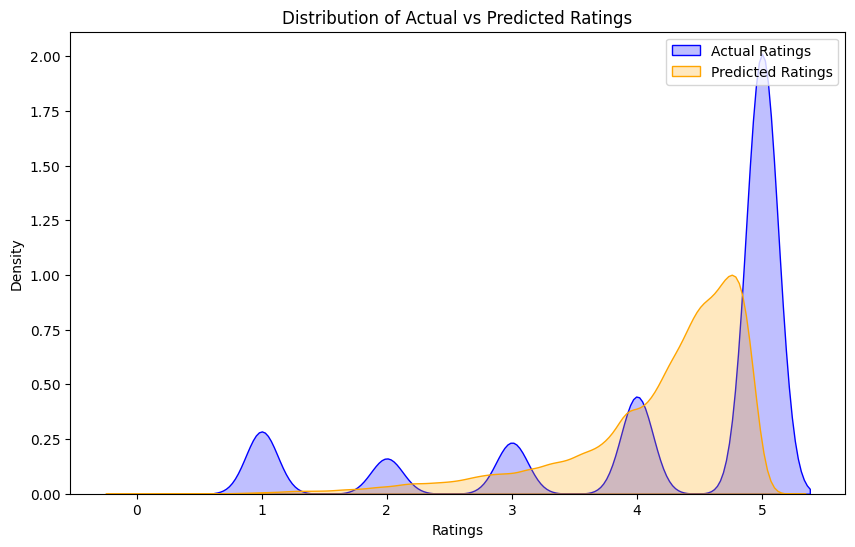

In [17]:
# Updated Distribution Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label="Actual Ratings", fill=True, color="blue")
sns.kdeplot(y_pred, label="Predicted Ratings", fill=True, color="orange")
plt.xlabel("Ratings")
plt.title("Distribution of Actual vs Predicted Ratings")
plt.legend()
plt.savefig(os.path.join(output_dir, 'distribution_plot.png'))
plt.show()

In [18]:
# Save Model Performance Metrics
with open(os.path.join(output_dir, 'model_performance.txt'), 'w') as f:
    f.write(f"Mean Squared Error: {mse}\n")
    f.write(f"R-squared: {r2}\n")

print("All steps completed and results saved in the 'output' folder.")

All steps completed and results saved in the 'output' folder.
